In [10]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [11]:
data_path = '/kaggle/input/bloodcellsaugmented/augmentationFinal.npz'
data1 = np.load(data_path)

X_train = data1['images']
y_train = data1['labels']

# Shuffle the data
shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

data_path = '/kaggle/input/bloodcellsaugmented/masked_dataset.npz'
data2 = np.load(data_path)

images2 = data2['processed_images']
labels2 = data2['labels']

shuffled_indices = np.random.permutation(len(images2))
images2 = images2[shuffled_indices]
labels2 = labels2[shuffled_indices]

unique_labels, label_counts = np.unique(labels2, return_counts=True)
labels2 = tfk.utils.to_categorical(labels2, num_classes=len(unique_labels))

print("training:")
print(X_train.shape)
print(y_train.shape)
print("validation-test:")
print(images2.shape)
print(labels2.shape)

training:
(47808, 96, 96, 3)
(47808, 8)
validation-test:
(11952, 96, 96, 3)
(11952, 8)


In [12]:
data_path = '/kaggle/input/bloodcellsaugmented/unique_images.npz'
data3 = np.load(data_path)

images3 = data3['images']
labels3 = data3['labels']

shuffled_indices = np.random.permutation(len(images2))
images3 = images3[shuffled_indices]
labels3 = labels3[shuffled_indices]

unique_labels, label_counts = np.unique(labels3, return_counts=True)
labels3 = tfk.utils.to_categorical(labels3, num_classes=len(unique_labels))

print(labels3.shape)

(11952, 8)


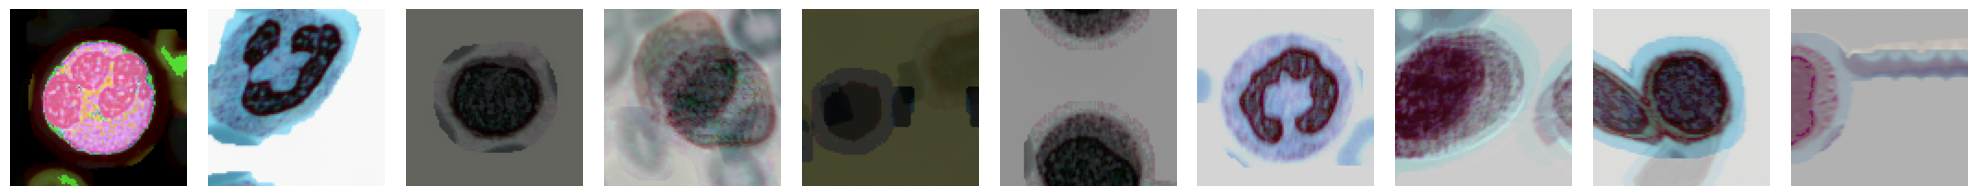

In [63]:
# Display a sample of images from the training-validation dataset
num_img = 10
random_indices = random.sample(range(len(X_train)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_train[idx]/255), vmin=0., vmax=1.)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [15]:
# too many samples for validation and test
# removing half of them

X_val1, useless1, y_val1, useless1 = train_test_split(
    images2,
    labels2,
    random_state=seed,
    test_size=0.5,
    stratify=np.argmax(labels2,axis=1)
)

X_val2, useless2, y_val2, useless2 = train_test_split(
    images3,
    labels3,
    random_state=seed,
    test_size=0.5,
    stratify=np.argmax(labels3,axis=1)
)


# Split data into train_val and test sets
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_val1,
    y_val1,
    random_state=seed,
    test_size=0.5,
    stratify=np.argmax(y_val1,axis=1)
)

# Split data into train_val and test sets
X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_val2,
    y_val2,
    random_state=seed,
    test_size=0.5,
    stratify=np.argmax(y_val2,axis=1)
)

X_val = np.concatenate((X_val1, X_val2), axis=0)
y_val = np.concatenate((y_val1, y_val2), axis=0)

X_test = np.concatenate((X_test1, X_test2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (47808, 96, 96, 3), y_train shape: (47808, 8)
X_val shape: (5976, 96, 96, 3), y_val shape: (5976, 8)
X_test shape: (5976, 96, 96, 3), y_test shape: (5976, 8)


In [16]:
# Penalizing minority classes more and prevent bias towards majority classes.

# Decoding one-hot labels to class indices
decoded_labels = np.argmax(y_train, axis=1) 

unique_labels, label_counts = np.unique(decoded_labels, return_counts=True)

total_images = len(decoded_labels) 
num_classes = len(unique_labels) 

category_weight = {}

for i in range(num_classes):
    category_weight[unique_labels[i]] = total_images / (num_classes * label_counts[i])

print(category_weight)

{0: 1.7555816686251469, 1: 0.6856356126663607, 2: 1.376958525345622, 3: 0.7385071675729116, 4: 1.7597173144876326, 5: 1.5060483870967742, 6: 0.6412017167381975, 7: 0.9093122337188071}


In [17]:
convnext = tfk.applications.ConvNeXtSmall(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(96,96,3),
    pooling='max',
)

# Display a summary of the model architecture
convnext.summary()

Model: "convnext_small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_pre… │ (None, 96, 96, 3) │          0 │ input_layer_5[0]… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_stem │ (None, 24, 24,    │      4,896 │ convnext_small_p… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │      4,800 │ convnext_small_s… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │        192 │ convnext_small_s… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │     37,248 │ convnext_small_s… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │          0 │ convnext_small_s… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │     36,960 │ convnext_small_s… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │         96 │ convnext_small_s… │
│ (LayerScale)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │          0 │ convnext_small_s… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 24, 24,    │          0 │ convnext_small_s… │
│                     │ 96)               │            │ convnext_small_s… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │      4,800 │ add_36[0][0]      │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │        192 │ convnext_small_s… │
│ (LayerNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │     37,248 │ convnext_small_s… │
│ (Dense)             │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │          0 │ convnext_small_s… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │     36,960 │ convnext_small_s… │
│ (Dense)             │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convnext_small_sta… │ (None, 24, 24,    │         96 │ convnext_small_s

 Total params: 49,454,688 (188.65 MB)

 Trainable params: 49,454,688 (188.65 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
convnext.trainable = False

# Unfreeze the top layers
for layer in convnext.layers[-50:]:
    layer.trainable = True

for layer in convnext.layers:
    if isinstance(layer, tfkl.Conv2D):
        layer.kernel_regularizer = tfk.regularizers.l2(1e-2)

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Pass through ConvNeXt backbone
x = convnext(inputs)



# Add dense and dropout layers
x = tfkl.Dense(128, activation="relu", kernel_regularizer=tfk.regularizers.l2(1e-2))(x)
x = tfkl.Dropout(0.4)(x)
x = tfkl.Dense(64, activation="relu", kernel_regularizer=tfk.regularizers.l2(1e-2))(x)
x = tfkl.Dropout(0.4)(x)

# Output layer
outputs = tfkl.Dense(y_train.shape[-1], activation="softmax", kernel_regularizer=tfk.regularizers.l2(1e-2))(x)

# Define the model
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Lion(learning_rate=1e-5),
    metrics=['accuracy']
)

tl_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 768)            │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,561,896 (189.06 MB)

 Trainable params: 37,213,896 (141.96 MB)

 Non-trainable params: 12,348,000 (47.10 MB)

In [21]:
# Train the model

tl_history = tl_model.fit(

    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=120,
    class_weight=category_weight,
    validation_data=(X_val, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]

).history



# Calculate and print the best validation accuracy achieved

final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file, including final accuracy in the filename

model_filename = '/kaggle/working/ConvNext' + str(final_val_accuracy) + '.keras'

tl_model.save(model_filename)


# Free memory by deleting the model instance

del tl_model

Epoch 1/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - accuracy: 0.7107 - loss: 4.0646 - val_accuracy: 0.9284 - val_loss: 3.1042
Epoch 2/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.9671 - loss: 2.7364 - val_accuracy: 0.9424 - val_loss: 2.4995
Epoch 3/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.9774 - loss: 2.1527 - val_accuracy: 0.9414 - val_loss: 2.0446
Epoch 4/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.9822 - loss: 1.6850 - val_accuracy: 0.9439 - val_loss: 1.5992
Epoch 5/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.9876 - loss: 1.2914 - val_accuracy: 0.9488 - val_loss: 1.2465
Epoch 6/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 95s 128ms/step - accuracy: 0.9900 - loss: 0.9889 - val_accuracy: 0.9292 - val_loss: 1.1293
Epoch 7/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - accuracy: 0.9908 - loss: 0.7658 - val_accuracy: 0.9391 - val_loss: 0.9021
Epoch 8/120
747/747 ━━━━━━━━━━━━━━━━━━━━ 95s 128ms/step - accuracy: 0.9929 

In [22]:
model = tfk.models.load_model('ConvNext96.47.keras')


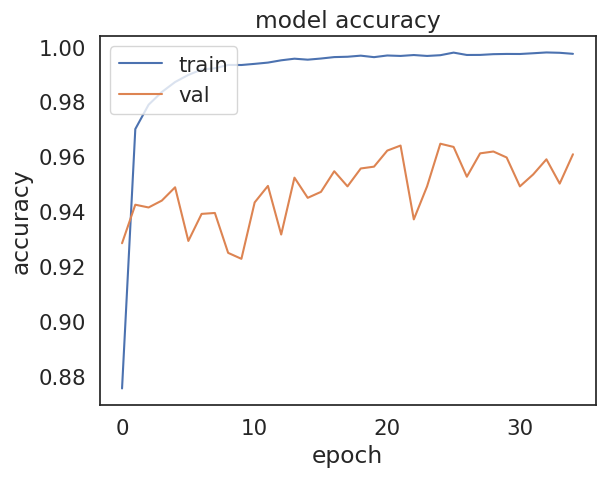

In [23]:
plt.plot(tl_history['accuracy'])
plt.plot(tl_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

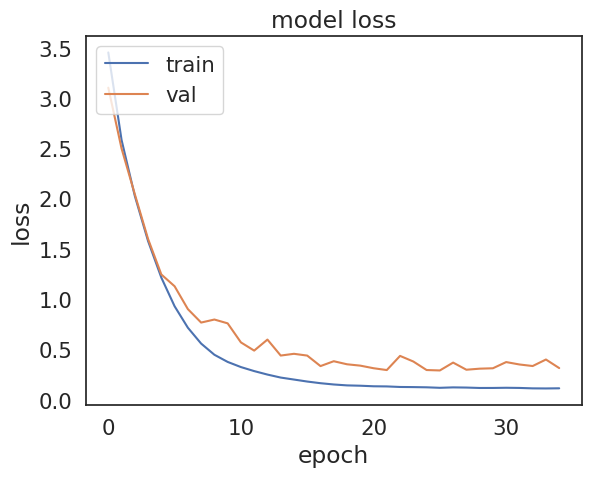

In [24]:
plt.plot(tl_history['loss'])
plt.plot(tl_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Accuracy score over the test set: 0.957
Precision score over the test set: 0.9587
Recall score over the test set: 0.957
F1 score over the test set: 0.9571


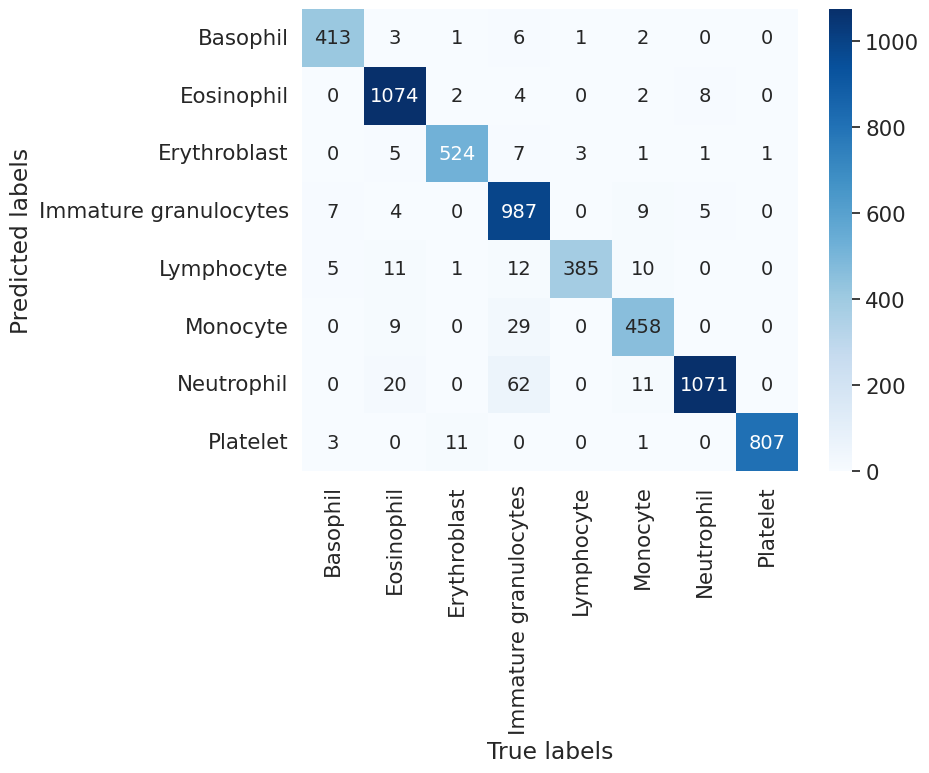

In [25]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


In [73]:
import keras_cv

rand_aug = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.5,
    magnitude_stddev=0.1,
    rate=0.9090909090909091,
    geometric=True,
    seed=42
)

In [74]:
X_test1 = rand_aug(X_test)

Accuracy score over the test set: 0.8999
Precision score over the test set: 0.9001
Recall score over the test set: 0.8999
F1 score over the test set: 0.8997


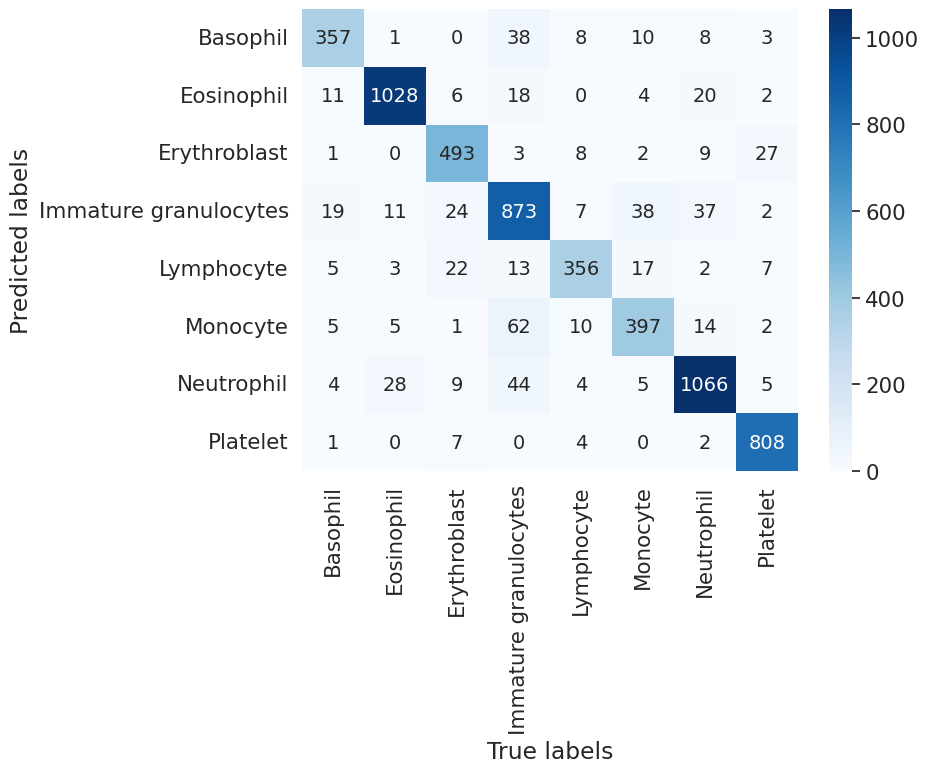

In [26]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test1, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast','Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()
